In [1]:
%matplotlib inline
from __future__ import division
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import struct
import pickle
import pandas as pd
import random

In [14]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.datasets import imdb
from keras.utils import to_categorical
from keras.layers import Conv1D, MaxPooling1D

In [4]:
import sys
sys.path.append('../../src')

In [5]:
from pylab import rcParams
from IPython.display import clear_output
rcParams['figure.figsize'] = 16, 8
pd.options.display.max_columns = 999

In [6]:
from utils import FloatConvert32, FloatConvert64
from microssembly2 import Microssembly
from price_generator import random_walk, random_price
from simple_strategy import plot_trades

In [7]:
def get_strategy_signal(price, short_ma, long_ma, demo=False):
    long_ma = abs(int(long_ma))
    shares = 1

    try:
        ml = price.rolling(long_ma).mean()

        buy = (ml > price) & (ml.shift() < price.shift())  # ma cross up
        sell = (ml < price) & (ml.shift() > price.shift())  # ma cross down
        signal = pd.Series(index=price.index)
        signal[buy[buy != False].index] = shares
        signal[sell[sell != False].index] = 0
    except Exception as e:
        print('Long {} Short {}'.format(long_ma, short_ma))
        raise e

    if demo is True:
        ax = price.plot()
        ml.plot()
        plt.legend(['price', 'Long MA'], loc='best')
        ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0.25)

    return signal

In [8]:
def plot_signals(observed_signal, signal):
    df = pd.DataFrame({'true': observed_signal - 0.5, 'generated': signal - 0.5}, index=observed_signal.index)
    ax = df.plot.bar()
    my_xticks = ['Sell', 'Buy']
    ax.set_yticks([-1, 1])
    ax.set_yticklabels(my_xticks)
    ax.set_xticklabels([])

In [9]:
def pad_left(series, n):
        head = series.index[0]
        pad_value = series[0]
        pad = pd.Series(np.full(n, pad_value), index=pd.date_range(start = head - pd.DateOffset(days=n-1),
                                                                   end = head) - pd.DateOffset(days=1))
        return pad.append(series)

In [10]:
def price_2_seq(price):
    p = (price - price.shift(1)).fillna(0)
    p = pad_left(p, 8 - 1)
    return np.array([p.shift(-x).values[:8] for x in range(len(p) - 7)[::]])

In [11]:
price = random_price(365 * 10)
signal = get_strategy_signal(price, 2, 5, False)
price.shape, signal.dropna().shape

((3651,), (1035,))

In [12]:
Y = to_categorical(signal.fillna(2).values)
x_train = price_2_seq(price)[:2000]
y_train = Y[:2000]
x_test = price_2_seq(price)[2000:]
y_test = Y[2000:]

In [30]:
model = Sequential()
model.add(LSTM(128, input_shape=(8, 1)))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [32]:
model.fit(np.expand_dims(x_train, axis=2), y_train,
          batch_size=32,
          epochs=15,
          validation_data=(np.expand_dims(x_test, axis=2), y_test))

Train on 2000 samples, validate on 1651 samples
Epoch 1/15
2000/2000 [==============================] - 2s 977us/step - loss: 0.8623 - val_loss: 0.7619
Epoch 2/15
2000/2000 [==============================] - 1s 395us/step - loss: 0.7590 - val_loss: 0.7284
Epoch 3/15
2000/2000 [==============================] - 1s 394us/step - loss: 0.6622 - val_loss: 0.5858
Epoch 4/15
2000/2000 [==============================] - 1s 395us/step - loss: 0.5465 - val_loss: 0.4765
Epoch 5/15
2000/2000 [==============================] - 1s 395us/step - loss: 0.4275 - val_loss: 0.3627
Epoch 6/15
2000/2000 [==============================] - 1s 393us/step - loss: 0.3471 - val_loss: 0.3091
Epoch 7/15
2000/2000 [==============================] - 1s 399us/step - loss: 0.2913 - val_loss: 0.2824
Epoch 8/15
2000/2000 [==============================] - 1s 399us/step - loss: 0.2826 - val_loss: 0.2716
Epoch 9/15
2000/2000 [==============================] - 1s 398us/step - loss: 0.2622 - val_loss: 0.2518
Epoch 10/15
2000

In [36]:
price = random_price()
signal = get_strategy_signal(price, 2, 5, False)

In [37]:
f = np.expand_dims(price_2_seq(price), axis=2)
predicted_signal = pd.Series(np.argmax(model.predict(f), axis=1), index=price.index).replace(2, np.nan)

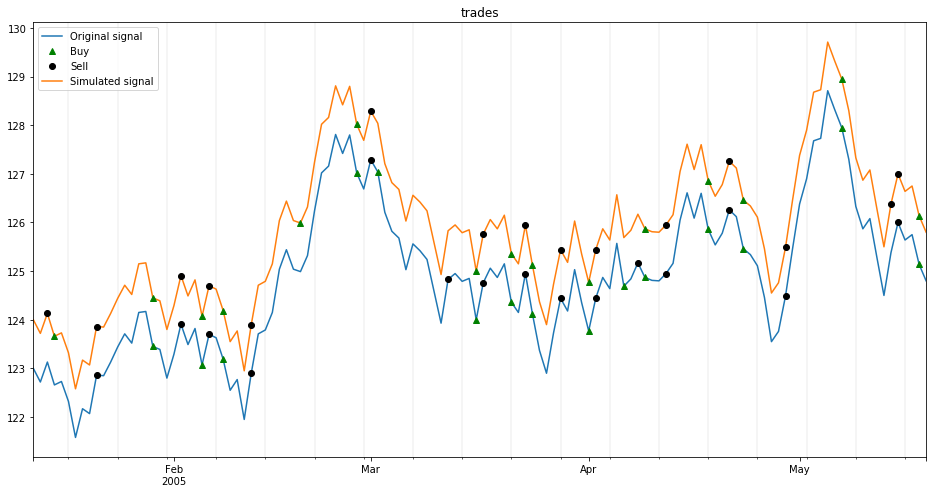

In [38]:
plot_trades(price, signal, plt)
plot_trades(price + 1, predicted_signal, plt)
plt.legend(['Original signal', 'Buy', 'Sell', 'Simulated signal'], loc='best')